# Twitter, Misinformation, and the 2020 Election

Hello and welcome to the final notebook for my Data Science Capstone Project! 

This project is aimed at a hypothetical team inside Twitter hoping to augment their moderation teams with data analysis and skills. This final notebook contains the best model for this purpose, some analysis of the results, and a way to test strings of text and see how the model predicts those strings.

Other notebooks in this repo detail how my data was gathered and how I chose the final model from other candidates.

### Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, plot_roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from nltk.corpus import stopwords


%matplotlib inline

# Most tweet_id's are so large that Pandas converted them to scientific notation. 
# I've opted to push that behavior out for now.    
pd.set_option("display.precision", 20)
np.set_printoptions(suppress=True)


# There's a few things down here that throw some warnings, so I've put this in here. No major issues.
import warnings
warnings.filterwarnings('ignore')

### Loading Data

Below I load in the 'rehydrated' tweets from my Election 2016 dataset. To see how I constructed the 'tweets_2016' file in detail please see the data collection notebooks.

Here I take the tweets, trim them to the critical columns, drop empty tweets, and assign them a binary identifier. 

In [2]:
control_df = pd.read_csv('tweets_2016')
l = ['tweet_text', 'tweet_id']
control_df =  control_df[l]
control_df['target'] = 0

# Most of these 'None' tweets once contained text, but if users were banned,
# suspended, or deleted their account after the initial data was collected. 
control_df= control_df[control_df.tweet_text != 'None']

control_df.head()

,tweet_text,tweet_id,target
0,RT @ReaganBattalion: Obama hates @marcorubio b...,789285389651570688.0,0
2,RT @lopezdoriga: EN DIRECTO en #Periscope: La ...,789329855565275136.0,0
3,RT @wikileaks: There is no US election. There ...,789324603516657664.0,0
7,RT @AJemaineClement: The lamest part of Trump'...,789269561203752960.0,0
14,@realDonaldTrump #AlSmithDinner #TrumpTapes #H...,789351683503562752.0,0


And here we load in the target database that includes the information labeled as misinformation. These rehydrated tweets come in the same format as the control dataframe above, so the process is identical, although obviously the target label has been set differently.

In [3]:
targetdf =  pd.read_csv('hydrated_tweets')
targetdf = targetdf[l]
targetdf['target'] = 1
targetdf= targetdf[targetdf.tweet_text != 'None']
targetdf.head()

,tweet_text,tweet_id,target
0,I'm not saying I believe there was widespread ...,1329817517590786054,1
1,Yes of course! https://t.co/YqpjvH0NoS,1330873630515896321,1
2,@RepPaulMitchell @realDonaldTrump Are you real...,1333262884357419010,1
3,Unity! https://t.co/I625kseVMn,1331653544579981314,1
4,Listen to this https://t.co/uhKFLA3GVz,1329835459200114688,1


Finally we join the two together into one big dataframe. I set the dataframe index to the unique tweet id's for later use during analysis. 

In [4]:
alldf = control_df.append(targetdf)
alldf.dropna(inplace=True)
alldf.set_index('tweet_id' , inplace=True)
alldf

,tweet_text,target
tweet_id,,
789285389651570688.0,RT @ReaganBattalion: Obama hates @marcorubio b...,0
789329855565275136.0,RT @lopezdoriga: EN DIRECTO en #Periscope: La ...,0
789324603516657664.0,RT @wikileaks: There is no US election. There ...,0
789269561203752960.0,RT @AJemaineClement: The lamest part of Trump'...,0
789351683503562752.0,@realDonaldTrump #AlSmithDinner #TrumpTapes #H...,0
...,...,...
1331497791944843264.0,@ACTBrigitte Count my family and friends. This...,1
1327465594090754048.0,@JudiciaryGOP @GOPChairwoman @GOP @GOPLeader @...,1
1331580447495696384.0,OMG https://t.co/QFx2mxyRmj,1


And so, once we've combined the dataframes and dropped the empty tweets, we finally have a final working dataframe of 73256 

### Train Test Split and Dummy Classifier

Here we split the data into training and validation sets. I use 42 to set random states throughout the project for repeateability purposes.

Additionally, I build a dummy pipeline and use a function here to collect cross validation scores, just to compare our final model to the baseline. Obviously during model iteration the various models were compared to each other.

In [5]:
X= alldf.tweet_text
y = alldf.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
#This creates a dictionary for the reportcrossval function to drop results into
cv_dict = {}

def reportcrossval(model, model_name, X, Y):
    # This function takes in a model, test data for both X and Y
    # It then adds the mean of the crossval scores to a dictionary called cv_dict
    # and prints the results out.
    
    cv_mean = cross_val_score(model, X, Y).mean()
    cv_dict[model_name] = cv_mean
    print(f"The cv mean of {model_name} is {cv_mean}")


In [7]:
pipe_dummy = Pipeline([('dummy', DummyClassifier(strategy='most_frequent'))], verbose=True)

reportcrossval(pipe_dummy, 'Dummy', X_train, y_train)

[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
The cv mean of Dummy is 0.5620654509624294


### The Final Model:

The final model chosen for this project is a random forest classifier. This model is more computationally intense than alternative models, but proved to be more accurate. 

This final model uses stopwords. Because the target dataframe was collected largely through network analysis, the tweets collected have a disproportionately high number of retweets and links. This confused some early models, which assigned high importance to certain strings related to links. Because of that I've augmented the default NLTK stopwords with 'rt', 'https', and 'co'. 

In [8]:
nltk_sw = stopwords.words('english')
tweetstop = ['https', 'co', 'rt']
for i in tweetstop:
    nltk_sw.append(i)

In [9]:
finalmodel = Pipeline(steps=[('cv', CountVectorizer(stop_words = nltk_sw)), 
                            ('rf', RandomForestClassifier(n_estimators = 500, random_state=42))],
                            verbose=True)
finalmodel.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.3s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.4min


Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(n_estimators=500, random_state=42))],
         verbose=True)

In [10]:
 reportcrossval(finalmodel, 'The Final Model', X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.0min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.0min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.1min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.1min
[Pipeline] ................ (step 1 of 2) Processing cv, total=   1.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.1min
The cv mean of The Final Model is 0.9935932689482015


### The Results:

Here we'll pick apart the results of our model and see what that can tell us about how the model can be deployed.

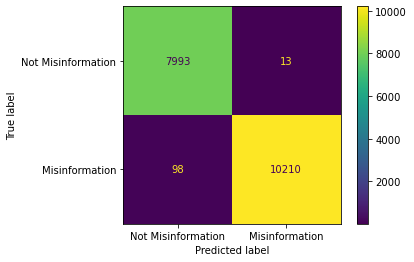

In [11]:
y_pred = finalmodel.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels =['Not Misinformation', 'Misinformation'] )

cmd.plot(values_format= 'd');

This is really good! Just 13 false positives from a test set of 18314, and only 98 false positives.

In [12]:
roc_auc_score(y_test, y_pred)

0.99443451947322

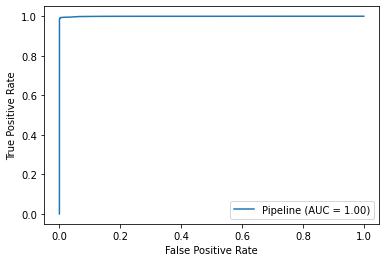

In [13]:
plot_roc_curve(finalmodel, X_test, y_test)

This is maybe the wrong way to visualize this. It's gratifying, but not helpful.

In [14]:
results_df = pd.DataFrame(y_test)
results_df['tweet_text'] = X_test
y_pred_proba = finalmodel.predict_proba(X_test)
y_pred_proba = pd.DataFrame(data = y_pred_proba, columns = ['pred0','pred1'])
results_df.insert(loc = 2, column = 'pred0' , value = y_pred_proba['pred0'].values)
results_df.insert(loc = 3, column = 'pred1' , value = y_pred_proba['pred1'].values)
results_df.insert(loc = 4, column = 'pred' , value = y_pred)

In [15]:
results_df

,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
789335093949050880.0,0,US-Wahl kompakt: Trump wird bei Benefiz-Dinner...,0.99799999999999999822,0.00200000000000000004,0
789331811981664256.0,0,RT @ObamaMalik: Trump family loves all people ...,1.00000000000000000000,0.00000000000000000000,0
1329829814249922560.0,1,@Timodc @BillKristol @Nate_Cohn @RVAT2020 I’m ...,0.00000000000000000000,1.00000000000000000000,1
789286228856274944.0,0,How Trump Will Create More ‘Bad Hombres’: The ...,0.99599999999999999645,0.00400000000000000008,0
1324622713193865216.0,1,"While evidence of VOTER FRAUD is coming in, th...",0.00000000000000000000,1.00000000000000000000,1
...,...,...,...,...,...
789263931260882944.0,0,RT @sageboggs: I miss the window in this elect...,1.00000000000000000000,0.00000000000000000000,0
789407616946479104.0,0,"RT @QuentinKidd: Women, NOVA, coll educ whites...",1.00000000000000000000,0.00000000000000000000,0
1325414016324259840.0,1,That Time When Joe Biden Bragged About Voter F...,0.00000000000000000000,1.00000000000000000000,1


In [16]:
errors_df = results_df[results_df['target'] != results_df['pred']]  

In [17]:
errors_df

,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
1329464227724210176.0,1,#Truth https://t.co/SZgFbPbjW2,0.78200000000000002842,0.21799999999999999933,0
1332402029571026944.0,1,@TherapyWestside @KamalaHarris @Official_tyler...,0.54400000000000003908,0.45600000000000001643,0
1330612952064520192.0,1,Why would they cover the windows???? No corrup...,0.92200000000000004174,0.07799999999999999989,0
1325049239353712640.0,1,😅😂😅😂😅😂😅😂😅 https://t.co/tf0Nw2N8FY,0.92000000000000003997,0.08000000000000000167,0
1325831415200669696.0,1,"Right on, my brother. We were warned way in ad...",0.96199999999999996625,0.03799999999999999906,0
...,...,...,...,...,...
1324143228363415552.0,1,Here's an interesting take. Didn't think about...,0.95999999999999996447,0.04000000000000000083,0
1329541189478064128.0,1,There should be an independent forensic ballot...,0.51800000000000001599,0.48199999999999998401,0
1324601076352385024.0,1,.@realDonaldTrump @FLOTUS @VP @EricTrump @Ivan...,0.90800000000000002931,0.09199999999999999845,0


In [18]:
false_neg_df = errors_df[errors_df['target'] == 1]
false_neg_df_sort = false_neg_df.sort_values(by = 'pred1')

false_neg_df_sort

,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
1329760854515052544.0,1,Fox News Calls Giuliani Liar After Conference ...,0.99799999999999999822,0.00200000000000000004,0
1322926947052277760.0,1,How is this not a conflict of interest? Trump...,0.99799999999999999822,0.00200000000000000004,0
1330316158885646336.0,1,Thats a fact. So much money and property at st...,0.99399999999999999467,0.00600000000000000012,0
1324543469801492480.0,1,Brazen!!! No shame!!!! @DonaldJTrumpJr @realDo...,0.97999999999999998224,0.02000000000000000042,0
1326411178545991680.0,1,"Lessons from WW2 were learned by this ""journal...",0.97599999999999997868,0.02400000000000000050,0
...,...,...,...,...,...
1329541189478064128.0,1,There should be an independent forensic ballot...,0.51800000000000001599,0.48199999999999998401,0
1329318761896226816.0,1,@Kiwicambo @bropologist @JackPosobiec @BobSpin...,0.50600000000000000533,0.49399999999999999467,0
1332900405014122496.0,1,@JakeCorman how can you sleep at night knowing...,0.50400000000000000355,0.49599999999999999645,0


In [19]:
most_confident_false_neg = false_neg_df.iloc[0:6].tweet_text.values

most_confident_false_neg

array(['#Truth https://t.co/SZgFbPbjW2',
       "@TherapyWestside @KamalaHarris @Official_tylerg Tell Kamala, that if she won legally as VP, she should resign her position on the Senate to win the trust of the people and stabilize things. She is already transitioning. She can't do both. People are losing confidence and believing Trump and the voter fraud scam.",
       'Why would they cover the windows???? No corruption here folks.. https://t.co/Bteeunis0w',
       '😅😂😅😂😅😂😅😂😅 https://t.co/tf0Nw2N8FY',
       "Right on, my brother. We were warned way in advance to expect exactly what they've done. The entire world knows Trump won! I've heard from scores in so many countries, they want a Trump of their own! \nTrump symbolizes victory over tyranny all over the world.🇺🇸\n@realDonaldTrump https://t.co/cYYz2gp4xX",
       '@stillgray Of course the queen of ballot harvesting!'],
      dtype=object)

In [22]:
false_pos_df = errors_df[errors_df['target'] == 0]
false_pos_df_sort = false_pos_df.sort_values(by = 'pred0')

false_pos_df_sort

,target,tweet_text,pred0,pred1,pred
tweet_id,,,,,
789254122188906496.0,0,RT @Bakari_Sellers: But but voter fraud... htt...,0.01000000000000000021,0.98999999999999999112,1
789305130361421824.0,0,Embattled sheriff trails in reelection bid.If ...,0.14399999999999998912,0.85599999999999998312,1
789255736085712896.0,0,#TrumpBookReports #WhyIWrite #HouseholdClassic...,0.14599999999999999090,0.85399999999999998135,1
789411907954278400.0,0,RT @TRUNEWS: .@JamesCarville Admits Democratic...,0.24399999999999999467,0.75600000000000000533,1
789319533450268672.0,0,RT @MedianPolitics: .@seanhannity @newtgingric...,0.25000000000000000000,0.75000000000000000000,1
789384716650631168.0,0,RT @CBS4Indy: Gov. Pence at Nevada rally: ‘Vot...,0.28399999999999997469,0.71599999999999996980,1
789340219438870528.0,0,RT @jewelry487jw62: Aren't the state's that Vo...,0.28599999999999997646,0.71399999999999996803,1
789340031764799488.0,0,RT @FOX59: Governor Mike Pence at rally: ‘Vote...,0.32000000000000000666,0.68000000000000004885,1
789323962408853504.0,0,RT @RoboHoward: Proof in Court that th 2000 el...,0.34200000000000002620,0.65800000000000002931,1


In [23]:
for i in false_pos_df_sort.tweet_text.values:
    print('')
    print(i)



RT @Bakari_Sellers: But but voter fraud... https://t.co/oP9LlzNoVF

Embattled sheriff trails in reelection bid.If he loses the voter fraud programmers will be executed on spot  https://t.co/I4ywuWuK1a

#TrumpBookReports #WhyIWrite #HouseholdClassicFilms #PodestaEmails13 #ObamaEmails #VoterFraud #IsReal @BillKristol https://t.co/erYVSIKTn1

RT @TRUNEWS: .@JamesCarville Admits Democratic #Election Fraud https://t.co/IBg20Jqnfr https://t.co/tGNmBVHAjC

RT @MedianPolitics: .@seanhannity @newtgingrich ELECTION FRAUD 
https://t.co/kNRl0EqGyU

RT @CBS4Indy: Gov. Pence at Nevada rally: ‘Voter fraud is real’ https://t.co/oOfGK5T7xT https://t.co/ZFKo3PsREs

RT @jewelry487jw62: Aren't the state's that Voter fraud seem's prevalent being scrutinized by RNC &amp; putting people in place to observe?V TR…

RT @FOX59: Governor Mike Pence at rally: ‘Voter fraud is real’ https://t.co/WtX0inAYK2 https://t.co/nWTfbRRDNS

RT @RoboHoward: Proof in Court that th 2000 election did have voter fraud!
@NetworksM

### In summation

I can dig into the specifics of each of these errors, but overall, the model is performing very well. 

Origionally I planned on using the ROC-AUC curve as the best overall metric for the model, because our hypothetical stakeholders could tweak the threshholds for a positive prediction to fit the needs and resources of their moderation teams, but with this performance, the model is doing well on basically any mertic. ROC-AUC, precision, F1, accuracy are all about as good as can be hoped.

I would feel very confident using this model to aid human descison making and to flag  problematic tweets.

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8006
           1       1.00      0.99      0.99     10308

    accuracy                           0.99     18314
   macro avg       0.99      0.99      0.99     18314
weighted avg       0.99      0.99      0.99     18314



## This model works very well with the data provided. 

Please see the readme and/or my presentation for some caveats and discussion of the limitations of the model.